## CLASSIFICATION of SPEECH FRAMES using DNNs in TORCH
+ ###### Author: Bob Van Dyck, Dirk Van Compernolle, Henry Grafé
+ ###### Modification History: 25/04/2022, 19/03/2023.8.3, 14/03/2025, 20/03/2025
+ ###### Requires:  pyspch>=0.8

## PURPOSE

This notebook demonstrates the construction of a simple DNN Classifier of Speech Frames.

This notebook is intended for students with little or no prior experience in deep learning. It introduces common concepts and terminology, such as network architecture, hidden layers, gradient descent, learning rate, and mini-batch learning.  

We use the PyTorch framework for the training.


In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings
### It is brute force .
### Best is not to run it when you want to debug code or new installations
import os, warnings
os.environ["OMP_NUM_THREADS"] = '2'
warnings.filterwarnings("ignore")
####################################################################################

### 1. Setting up

This step is to install the `pyspch` module. We will use `pyspch` for loading the TIMIT dataset, as well as computing error metrics.

In [2]:
!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab,
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

  Cloning https://github.com/compi1234/pyspch.git to /tmp/pip-req-build-6uch41ru
  Running command git clone --filter=blob:none --quiet https://github.com/compi1234/pyspch.git /tmp/pip-req-build-6uch41ru
  Resolved https://github.com/compi1234/pyspch.git to commit 4a7892894fadda9d1d7dabf9bd4305352bd26a18
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
  Created wheel for pyspch: filename=pyspch-0.8.3-py3-none-any.whl size=13931024 sha256=7fb8825c0468e190d2c8f1d14c3384f9dd6be1b76fef3a58e382a888ca1adc39
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0usil32/wheels/7a/a3/e6/c203dcb3c4447f7380a612758b80685a0444509b9b89f117f7
Successfully built pyspch


Here we load the necessary modules. Reviewing these modules may be helpful if you have limited experience with Python, as they are commonly used in machine learning. We have:

- `matplotlib` : used to plot graphs.
- `numpy` : for efficient computations using arrays.
- `pandas` : a library for loading, creating, and manipulating datasets.
- `scipy` : functions commonly used in scientific computing, including signal processing.
- `seaborn` : other library to plot graphs, here we use it only for its color palettes.
- `torch` : PyTorch, aka torch, the library of interest here. It is primarily used for efficiently training deep neural networks on a CPU or GPU.

In [3]:
%matplotlib inline
import io, os, sys
import logging
import urllib.request

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import torch
from scipy.fftpack import dct

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

# logging (see pyspch.nn.train())
logging.basicConfig(level=logging.WARNING)
# pyspch
import pyspch
import pyspch.nn
from pyspch.stats import GMM
import pyspch.core as Spch

#
from pyspch.core.utils_clf import train_GMM, train_MLP, test_clf
from pyspch.core.utils_timit import load_timit_data, print_dataset_statistics, select_subset

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

In the next cell, we set the color palette for the plots for aesthetic purposes.

In [4]:
# choose the colors you like :)
palette = sns.color_palette("bright")
# palette=['red','green','blue','orange','brown','black','dodgerblue','mediumturquoise','cyan','violet','gold','salmon']
# sns.palplot(palette)
sns.set_palette(palette)

#### Dataset Formatting

TIMIT is a widely used dataset for speech recognition. It contains approximately 5 hours of speech from 630 different American English speakers. (TI stands for Texas Instruments, where the dataset was recorded, and MIT refers to the Massachusetts Institute of Technology, where the recordings were annotated.)

By today's standards, this is a very small dataset—state-of-the-art models are trained on millions of hours of speech. However, its main advantage is that it is annotated at the phoneme level.

For each sentence, the start and end times of each phoneme are recorded. This allows us to assign a phoneme label to each spectrogram frame of an utterance.

The figure below shows an example utterance from TIMIT with the phoneme-level annotation.


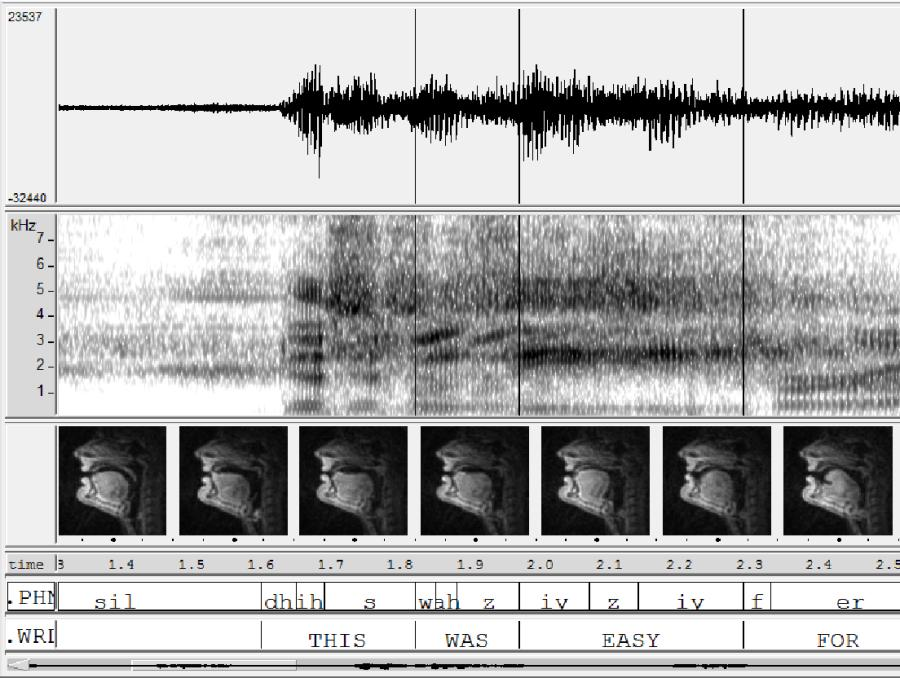

For this exercise session, we will perform a basic classification of speech frames. The model's task is to predict the phoneme class of a given spectrogram frame.

In the following cells, we load the TIMIT dataset and convert it into NumPy arrays. Each instance of the dataset corresponds to:
- a spectral frame, which is one of the frames of the Mel spectrogram. We load 80-band Mel spectrogram frames, but you can change the variable to experiment with 24-band Mel spectrogram frames or 13-dimensional MFCC frames.
- the corresponding phoneme label (1 out of 41 possible phonemes).

The dataset is divided into a training set and a test set. The training set is used to train the model with gradient descent, and the test set is used to evaluate the model’s performance. The number of samples per class for the training and test sets is printed in the cell below.

The training and test sets are stored as NumPy arrays:
- an array of floats of shape (`n_dataset_samples`, `mel_dim`), where `n_dataset_samples` is the number of samples in the dataset, and `mel_dim` is the dimension of each spectral frame (80 if we use 80-band Mel spectrogram frames).
- an array of shape (`n_dataset_samples`,) containing the labels for each sample.

In [5]:
def extract_Xy(data):
    X = data.get_features_as_numpy()
    y = data.get_labels_as_numpy()
    return X, y

# Define phoneme alphabet
alphabet = "timit41"

# The suffix "_si" specifies that we only take the "Speaker-Independent" or "si" sentences,
# which are unique sentences spoken by only one speaker in TIMIT, as opposed to "Speaker-Adaptive"
# sentences, which are the same sentences spoken by all the speakers of the dataset.
suffix = "_si"

# Load phoneme alphabet
timit41 = pyspch.timit.get_timit_alphabet("timit41")

# Select feature type
ftrs = "mel80"  # Options: "mfcc13", "mel24", or "mel80"

# Feature modification settings
modify_feature_args = {}  # Example: {"Norm": "meanvar", "Deltas": "delta", "n_cep": 24}

# Load training data
data = load_timit_data(corpus=f"train{suffix}", ftrs=ftrs, alphabet=alphabet)
X_timit_train, y_timit_train = extract_Xy(data)

# Load test data
data = load_timit_data(corpus=f"test{suffix}", ftrs=ftrs, alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_test, y_timit_test = extract_Xy(data)


The classification task will involve one of these three sets of categories:
- 3 vowel classes
- 6 vowel classes
- 6 plosive classes

In a full speech recognition system, frames would be classified into one of the 41 phoneme categories of TIMIT. This simplification allows us to train the models within a reasonable time.

You can select the classification task by setting the `classes` variable.

In [6]:
timit41 = pyspch.timit.get_timit_alphabet('timit41')
vowel3=['iy','aa','uw']
vowel6=['iy','aa','uw','ih','eh','er']
plosives=['p','t','k','b','d','g']
classes = plosives

In our case, we do not take all the frames corresponding to a phoneme, as this would make the dataset too large to train within the session.

We downsample the dataset by a factor of `downsample`. This means we select every `downsample`-th frame for our classification task. We also ensure that each class has at least `mincount` frames.

In [7]:
downsample = 10
mincount=512
X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,downsample=downsample,mincount=mincount)
X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,downsample=downsample,mincount=mincount)
print("STATISTICS for TIMIT SUBCORPUS (%s), downsampled(%d) "%(suffix,downsample))
print_dataset_statistics(y_train,Details=True,txt="Train Database")
print_dataset_statistics(y_test,Details=True,txt="Test Database")

STATISTICS for TIMIT SUBCORPUS (_si), downsampled(10) 
Statistics for Train Database:
Number of classes 6
Number of samples 4229
Minimun/Maximum number of samples per class:  544  /  1027
[(np.str_('b'), np.int64(768)), (np.str_('d'), np.int64(601)), (np.str_('g'), np.int64(544)), (np.str_('k'), np.int64(706)), (np.str_('p'), np.int64(583)), (np.str_('t'), np.int64(1027))]
Statistics for Test Database:
Number of classes 6
Number of samples 3565
Minimun/Maximum number of samples per class:  403  /  930
[(np.str_('b'), np.int64(552)), (np.str_('d'), np.int64(930)), (np.str_('g'), np.int64(403)), (np.str_('k'), np.int64(569)), (np.str_('p'), np.int64(547)), (np.str_('t'), np.int64(564))]


#### Feature visualization


Before training the neural network, we will visualize the dataset.

In this cell, we use `sklearn` to apply PCA to the data. PCA is a simple dimensionality reduction technique that reduces a high-dimensional vector (here, the 80-dimensional mel spectrogram frames) into a lower-dimensional vector. The dimensions are chosen to maximize the variance they capture.

In [8]:
from sklearn.decomposition import PCA

# A. Filterbank Energies (spectral features)
FB_train = X_train
FB_test = X_test

# B. PCA features (Principle Component Analysis)
pca = PCA()
T = pca.fit(FB_train)
PCA_train = T.transform(FB_train)
PCA_test = T.transform(FB_test)

The following cells perform PCA on the mel spectrogram frames and plot the first three PCA dimensions. The resulting nine plots show the following:
- The diagonal plots show the histogram of class distributions along each of the three PCA dimensions.
- The other plots display one PCA dimension (1, 2, or 3) against another in a 2D scatter plot.

Question:

- Would a classifier using the three PCA dimensions plotted here perform well in classifying phonemes? (Not a trick question.)

<Figure size 1000x1000 with 0 Axes>

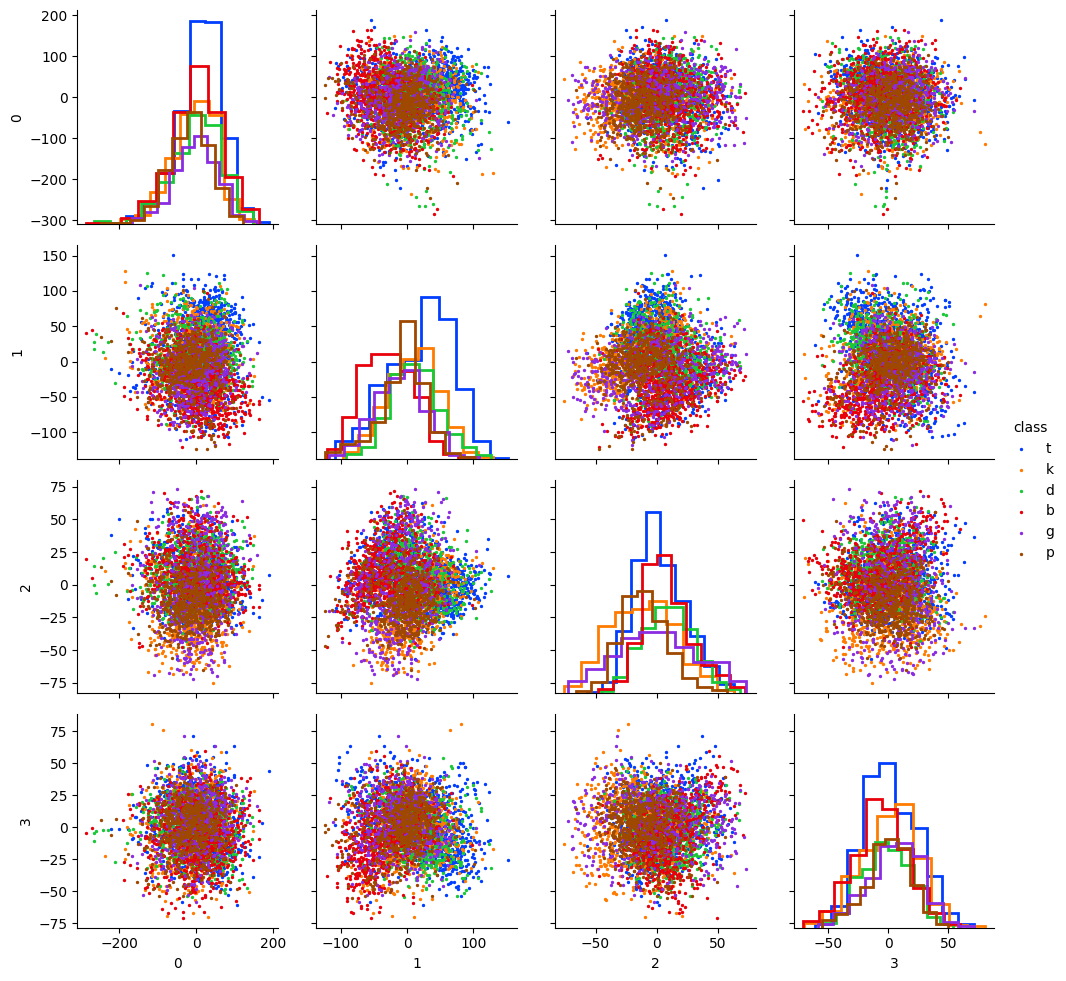

In [9]:
# Define a number of different Features

# A. PCA features (Principle Component Analysis)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
PCA_df = pd.concat([dfy, dfX], axis=1)

# choose feature set to use in plots and experiments
df = PCA_df
df.columns = ["class","0","1","2","3"]

doPlot = True
if doPlot:
  # plot 2 first dimensions of feature
  f=plt.figure(figsize=(10, 10))
  #sns.scatterplot(data=df, x="0", y="1", hue='class')

  # plot all dimensions pairwise
  g = sns.PairGrid(df, hue="class")
  g.map_diag(plt.hist, histtype="step", linewidth=2)
  g.map_offdiag(plt.scatter, s=2)
  g.add_legend()

Now, we will build and train the Deep Neural Network (DNN).

We will first define the DNN model that we will use for classification with PyTorch. In PyTorch, a model is defined as a class that inherits from `torch.nn.Module`. Aside from the `__init__` function, we must also implement the `forward` function, which defines how the model processes an input.

We also define an `init_weights` function, which will initialize the weights of the layers of the DNN with numbers sampled from a normal distribution. This is done so that the network trains faster.

Read the code and comments to get an idea of how this is all done.

In [10]:
# =============================================================================
# Define Classes for Neural Network Architecture and Datasets
# =============================================================================

# Simple feedforward neural network
class SimpleFFNN(torch.nn.Module):

    def __init__(self, in_dim, out_dim, hidden_layer_sizes):
        super(SimpleFFNN, self).__init__()

        # The dimension of the input data (=80 for 80-band mel spectrogram frames)
        self.in_dim = in_dim

        # The output dimension (since we perform a classification task with 6 classes, it will be =6)
        self.out_dim = out_dim

        # The number and dimensions of the hidden layers. It is a list encoding the dimension of each hidden layer.
        # For example, [512, 512] means there are 2 hidden layers, each with 512 dimensions.
        self.hidden_layer_sizes = hidden_layer_sizes

        # Instantiate the actual layers and store them in a torch.nn.ModuleList.
        # Then, use a torch.nn.Sequential module to "stack" all layers together,
        # so that they do not have to be called separately in forward().
        modulelist = torch.nn.ModuleList([])

        # First layer: Linear projection from in_dim to first hidden layer's dim, followed by a nonlinearity.
        modulelist.append(torch.nn.Linear(self.in_dim, hidden_layer_sizes[0]))
        # We use LeakyReLU as the nonlinearity, but you can experiment with others (Sigmoid, ReLU, SiLU, GELU, etc.).
        modulelist.append(torch.nn.LeakyReLU())

        for i in range(len(hidden_layer_sizes) - 1):
            # Hidden layers: Linear projection from previous hidden layer to the next, followed by a nonlinearity.
            modulelist.append(torch.nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
            modulelist.append(torch.nn.LeakyReLU())

        # Last layer: Linear projection from the last hidden layer's dim to the output dim.
        modulelist.append(torch.nn.Linear(hidden_layer_sizes[-1], self.out_dim))

        # Stack all layers together for convenience.
        self.net = torch.nn.Sequential(*modulelist)

    def forward(self, x):
        # Shape of x: (BATCH_SIZE, in_dim)
        # Pass the data through all layers.
        return self.net(x)

    def init_weights(self):
        # Apply Kaiming initialization to all linear layers.
        self.net.apply(self.init_normal)

    # Weight initialization
    def init_normal(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)


To train a model with PyTorch, we also need to encapsulate the TIMIT dataset in a class. The class inherits the `torch.utils.data.Dataset` class, and we need to implement the following methods:
- `__len__` must give the total number of samples in the dataset.
- `__getitem__(i)` must give the ith item of the dataset as a tuple (spectral frame, label).

We also include a `split` function that divides the training set into two subsets: a validation set and a training set. The validation set is used to track the progress of the model as `i`-th trains. The test set is used only after training is complete. This is a common practice in machine learning.

In [11]:
# Dataset
class SimpleDataset(torch.utils.data.Dataset):
    """A simple dataset class for frame-level phoneme classification."""

    def __init__(self, data_X, data_y, labels, labeldict, device):

        # Dimensionality
        self.n_samples, self.n_features = data_X.shape
        self.n_classes = len(labels)

        # Input data
        self.frames = data_X  # (n_samples, n_features)
        self.frames = torch.as_tensor(self.frames, dtype=torch.float32).to(device)

        # Labels
        if data_y.dtype != np.int64:
            data_y = np.vectorize(labeldict.get)(data_y)
        self.labels = torch.as_tensor(data_y, dtype=torch.long).to(device)

    def split(self, frac=None, seed=None):
        if frac is None:
            return None, self
        else:
            if seed is not None:
                torch.manual_seed(seed)
            n_split = int(len(self) * frac)
            # We use a torch function to randomly split the data into two sets
            return torch.utils.data.random_split(self, [n_split, len(self) - n_split])

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        """Retrieves a data sample and its corresponding label from the dataset."""
        frame = self.frames[idx]
        label = self.labels[idx]
        return frame, label


In [12]:
# Features (X) and labels (y) used for the experiment

# Input data
train_X = FB_train  # The mel spectrogram frames that we used earlier
test_X = FB_test

# Define One-Hot Encoding for labels
labels = classes
labeldict = {classes[i]: i for i in range(len(labels))}  # We map each label to a number, as labels must be represented as integers in PyTorch
inv_labeldict = {v: k for k, v in labeldict.items()}  # We also create a dictionary for reverse conversion, for convenience

# Encode labels
train_y = np.vectorize(labeldict.get)(y_train).astype(np.int64)
test_y = np.vectorize(labeldict.get)(y_test).astype(np.int64)

# Dataset and DataLoader for easy mini-batch sampling

# Construct dataset
train_ds = SimpleDataset(train_X, train_y, labels, labeldict, device)
test_ds = SimpleDataset(test_X, test_y, labels, labeldict, device)


## Gradient Descent

A neural network is trained using *mini-batch gradient descent*. We divide the dataset into mini-batches of several samples, pass them through the neural network, and compare the predictions with the ground truth labels using a loss function. We then backpropagate the loss value so that we know by how much to change each parameter of the network to minimize the loss.

For a classification task, the most common loss is the *cross-entropy*. Assuming we have the probabilities output by the model for each class (by applying a softmax to the output of the neural network), the loss is as follows:

$$\mathcal{L} = - \frac{1}{B} \sum_{i=1}^{B} \log p^i_{l(i)}$$

where $B$ is the size of the mini-batch, $l(i)$ is the ground truth label of element $i$ in the mini-batch, and $p^i_{l(i)}$ is the probability predicted by the model that instance $i$ belongs to label $l(i)$. By minimizing this, we maximize the model's ability to predict the ground truth label of each instance.

The loss function is already available in PyTorch as `torch.nn.CrossEntropyLoss`. This function takes as input the logits produced by the neural network, meaning the numbers before applying softmax. The softmax operation is applied inside the loss function.

After computing the loss, we compute the gradients with respect to it and update all parameters so that the network’s predictions improve in the next iteration. The parameter update is done with the PyTorch *optimizer* object `torch.optim.Adam()`. The `Adam` optimizer does more than simply compute the gradients (it also uses momentum), but this falls outside the scope of this session.

An extreme case of mini-batch gradient descent is when the mini-batch includes the entire dataset. In this case, it is called *batch gradient descent*. In both cases, going over the entire dataset one time is called an *epoch*.

The next code cell implements how the model trains for one epoch. Read it to understand what it is doing.


In [13]:
def train_epoch(model, train_dl, loss_function, optimizer, clip_args=None):
    model.train()
    epoch_loss = 0

    # Iterate over batches
    for batch in iter(train_dl):
        # Reset gradients before starting a new step
        optimizer.zero_grad()

        # Forward pass: the neural network generates predictions
        inputs, targets = batch
        outputs = model(inputs)

        # Compute the cross-entropy loss
        loss = loss_function(outputs, targets)

        # Backward pass: compute gradients for each parameter
        loss.backward()
        if clip_args:
            torch.nn.utils.clip_grad_norm_(model.parameters(), **clip_args)

        # Update model parameters using the optimizer
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_dl)


To train the model for multiple epochs, we create another function `train`. This function takes as input the model, the train and validation dataset, an optimizer, and a learning rate scheduler. A learning rate scheduler allows you to change how much you adjust the model's parameters during an optimization step as you train. We do not use a scheduler in this session and instead use a constant learning rate.

The function will train for a certain number of epochs, and at the end of each epoch, it will compute the loss on the validation set using the `evaluate` function. We also implement an `EarlyStop` mechanism, which stops training if the validation loss does not improve for a set number of epochs.


In [14]:
import torch
import logging
from tqdm import tqdm

class EarlyStop:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def update(self, loss):
        if loss < self.best_loss:
            self.counter = 0
            self.best_loss = loss
        else:
            self.counter += 1

    def stop(self):
        return self.counter > self.patience

def train(model, train_dl, loss_function, optimizer, scheduler=None, n_epochs=500,
          valid_dl=None, patience=5):
    """Perform mini-batch gradient descent with early stopping."""

    # Training and validation loss
    train_losses = []
    valid_losses = []

    # Train
    earlystop = EarlyStop(patience)
    for epoch in tqdm(range(n_epochs)):

        # Train epoch
        train_loss = train_epoch(model, train_dl, loss_function, optimizer)
        train_losses.append(train_loss)

        # Early stopping
        if valid_dl is not None:
            valid_loss = evaluate(model, valid_dl, loss_function)
            valid_losses.append(valid_loss)
            earlystop.update(valid_loss)
            if earlystop.stop():
                logging.info("\t -- Stop early")
                break

        # Update scheduler
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                metrics = train_loss if valid_dl is None else valid_loss
                scheduler.step(metrics)
            else:
                scheduler.step()
                new_lr = scheduler.get_last_lr()[0]
                logging.info("\t -- New LR: %.6f" % new_lr)

    return train_losses, valid_losses

def evaluate(model, iterator, criterion):
    """Evaluate the model and compute average loss."""

    model.eval()
    running_loss = 0

    # Compute average loss
    with torch.no_grad():
        for batch in iterator:
            # Forward pass
            inputs, targets = batch
            outputs = model(inputs)
            # Loss
            loss = criterion(outputs, targets)
            running_loss += loss.item()

    average_loss = running_loss / len(iterator)
    return average_loss


Now, we put everything together and start training. We instantiate the model, loss function, optimizer, learning rate scheduler, and datasets.

In order to efficiently load the data in mini-batches, PyTorch also has a `torch.utils.data.DataLoader` class, in which we input the dataset and the batch size.

The model trains for `n_epochs`, and the train and validation losses are then plotted.

Questions:

- What is the trajectory of the train loss? What is the trajectory of the validation loss? If there is a difference, why is that?
- Experiment with changing the hyperparameters (number of hidden layers, dimensions of the hidden layers) of the model. Do you see any difference in the training?


 52%|█████▏    | 104/200 [00:30<00:27,  3.46it/s]


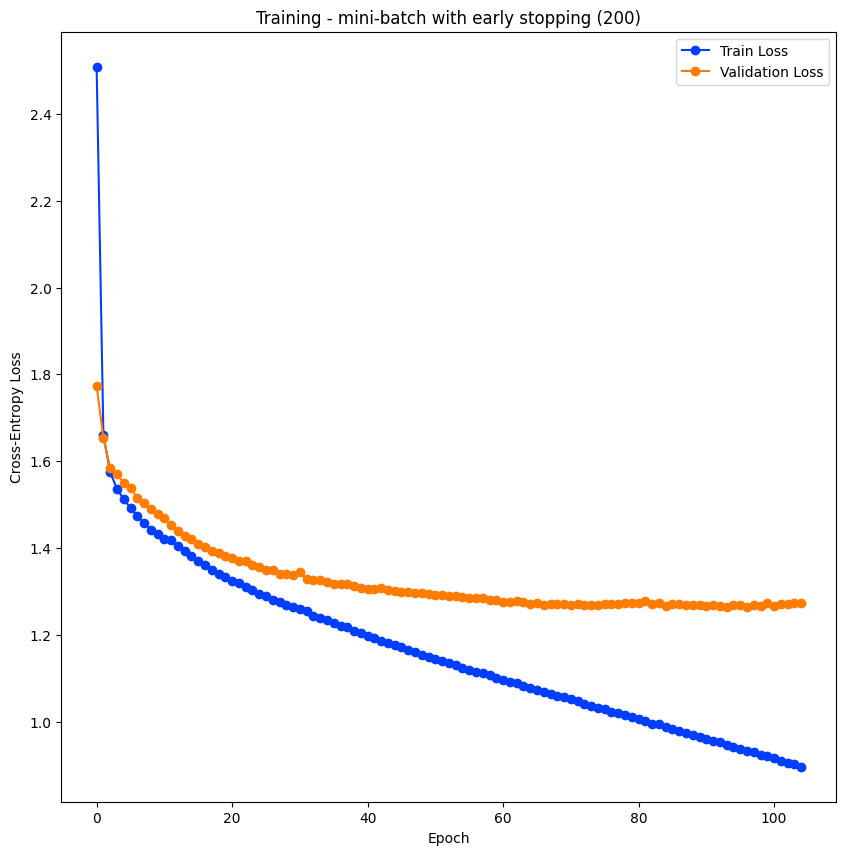

In [21]:
# General training setup

spectral_frame_dim = train_X.shape[1]
num_classes = len(labels)

lr = 0.0001
seed = 1234

loss_function = torch.nn.CrossEntropyLoss()  # Loss function [applies softmax() inside]
scheduler = None  # Learning rate scheduler

# Variations
n_epochs = 200  # The number of epochs we train the model
batch_size = 128  # The number of samples in each mini-batch
patience = 10  # How long we wait after we have found a new best validation loss before stopping early
val_frac = 0.1  # Share of the train set that will be used for the validation set
name = "mini-batch with early stopping"

# Initialize model & optimizer
model = SimpleFFNN(in_dim=spectral_frame_dim, out_dim=num_classes, hidden_layer_sizes=[512, 512]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Ties model parameters to optimizer (back-propagation)

# Splitting the train set into train and validation sets
train_ds = SimpleDataset(train_X, train_y, labels, labeldict, device)
valid_ds, train_ds = train_ds.split(val_frac, seed)

# Making the dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size)

test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

# Train
train_loss, val_loss = train(
    model, train_dl,
    loss_function, optimizer,
    scheduler,
    n_epochs,
    valid_dl, patience
)

# Plot training loss
plt.figure()
plt.plot(train_loss, 'o-', label="Train Loss")
plt.plot(val_loss, 'o-', label="Validation Loss")
plt.title("Training - " + name + " (" + str(n_epochs) + ")")
plt.ylabel("Cross-Entropy Loss")
plt.xlabel("Epoch")
plt.legend()


## Evaluating the Trained Model

In this cell, we evaluate the trained model on the test set (until now, we only evaluated on the validation set).  
The Phoneme Error Rate (PER), which represents the rate at which the phoneme class predictions of the model were correct, is printed.

The PER for each separate phone class is also printed.

Questions (Plosives Classification Task)
- Is there a difference in PER for different phone classes? Why is that the case? (Clue: look at the composition of the training set)

We plot the so-called **"confusion matrix."** The vertical axis of the matrix is the ground truth label,  
and the horizontal axis is the predicted label. This way, we can see which elements of a certain ground truth label were predicted as other classes.

Questions (Plosives Classification Task)
- What is the most common confusion between prediction and ground truth that the model makes? Does it make sense?
- What are the more "surprising" confusions that the model makes?


PER 0.55 and PER per phone class [0.6197 0.273  0.529  0.4728 0.7269 0.5583]
CE Loss 1.44


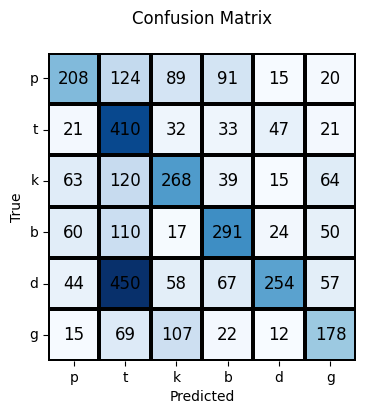

(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Confusion Matrix\n'}, xlabel='Predicted', ylabel='True'>)

In [23]:
# Confusion matrix
cm = pyspch.nn.evaluate_cm(model, test_dl)

# Phone Error Rate (PER) + PER per phone class
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f and PER per phone class %s" % (per, np.round(per_pc, 4)))

# Cross-entropy loss
print("CE Loss %.2f" % pyspch.nn.evaluate(model, test_dl, loss_function))

# plot
pyspch.plot_confusion_matrix(cm, classes)
